In [1]:
import os 
os.environ['CUDA_VISIBLE_DEVICES'] = '3'
os.environ['DDE_BACKEND'] = 'pytorch'

In [2]:
import deepxde as dde
import torch 
import numpy as np 
import matplotlib.pyplot as plt

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.
/userhome/jeon_mg/miniforge3/envs/pinn_torch/lib/python3.10/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /opt/conda/conda-bld/pytorch_1695392020201/work/torch/csrc/tensor/python_tensor.cpp:451.)
  _C._set_default_tensor_type(t)


In [3]:
def pde(t, u):
    du_t = dde.grad.jacobian(u, t)
    pde_u = du_t - torch.cos(2 * np.pi * t)
    return pde_u

In [4]:
def boundary(t, on_initial):
    return on_initial and np.isclose(t[0], 0)

In [5]:
geom = dde.geometry.TimeDomain(0, 2)

ic = dde.IC(geom, lambda t: 1, boundary)

In [6]:
def true_solution(t):
    return np.sin(2*np.pi*t)/(2*np.pi) + 1

In [7]:
data = dde.data.PDE(geom,
                    pde,
                    ic,
                    num_domain=30,
                    num_boundary=2,
                    num_test=100,
                    train_distribution='LHS',
                    solution=true_solution)

In [8]:
layer_size = [1] + [32] + [1]
activation = 'tanh'
initializer = 'Glorot uniform'

net = dde.maps.FNN(layer_size, activation, initializer)

In [9]:
model = dde.Model(data, net)
model.compile('adam', lr=1e-3)

Compiling model...
'compile' took 0.306694 s



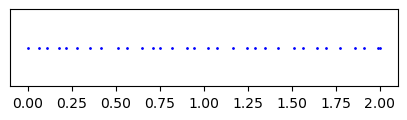

In [10]:
plt.figure(figsize=(5, 1))
plt.scatter(data.train_x_all, np.ones_like(data.train_x_all), c='b', s=1)
plt.yticks([])
plt.show()

In [11]:
t = geom.uniform_points(100)
u_true = true_solution(t)
u_pred = model.predict(t)
dde.metrics.l2_relative_error(u_true, u_pred)

1.8213605

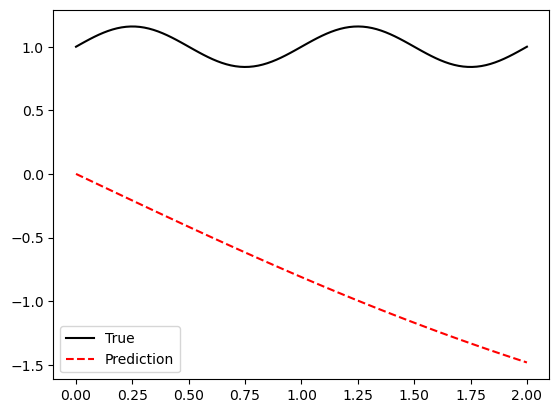

In [12]:
plt.plot(t, u_true, 'k', label='True')
plt.plot(t, u_pred, 'r--', label='Prediction')
plt.legend()
plt.show()

Training model...

Step      Train loss              Test loss               Test metric
0         [1.18e+00, 1.00e+00]    [1.03e+00, 1.00e+00]    []  
1000      [5.02e-01, 2.25e-06]    [4.99e-01, 2.25e-06]    []  
2000      [4.90e-01, 2.05e-05]    [4.93e-01, 2.05e-05]    []  
3000      [4.23e-01, 2.83e-09]    [4.50e-01, 2.83e-09]    []  
4000      [2.83e-01, 5.02e-06]    [2.74e-01, 5.02e-06]    []  
5000      [5.80e-03, 2.16e-09]    [5.65e-03, 2.16e-09]    []  
6000      [2.87e-03, 6.96e-13]    [2.42e-03, 6.96e-13]    []  

Best model at step 6000:
  train loss: 2.87e-03
  test loss: 2.42e-03
  test metric: []

'train' took 25.003245 s



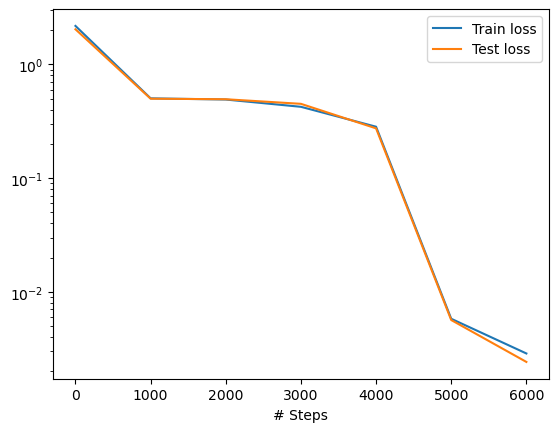

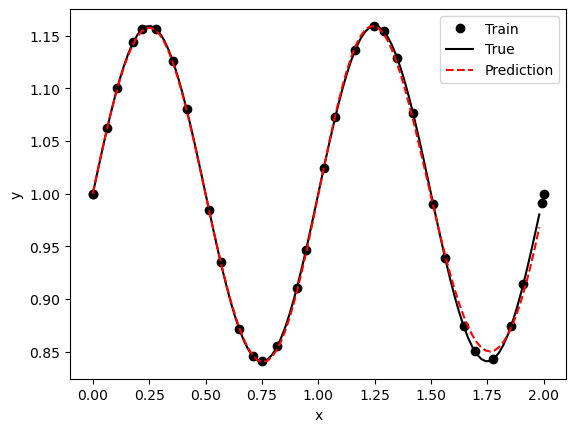

In [13]:
losshistory, train_state = model.train(iterations=6000)
dde.saveplot(losshistory, train_state, issave=False, isplot=True)

In [14]:
t = geom.uniform_points(100)
u_true = true_solution(t)
u_pred = model.predict(t)
dde.metrics.l2_relative_error(u_true, u_pred)

0.00464723

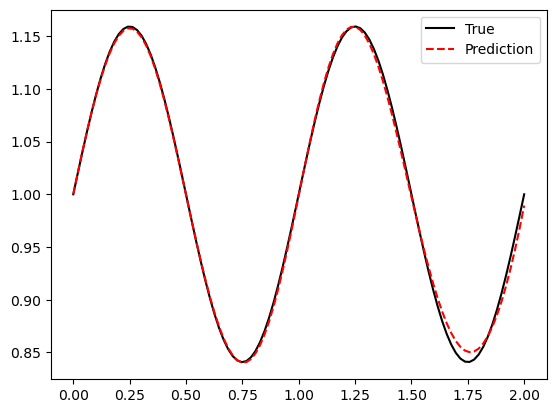

In [15]:
plt.plot(t, u_true, 'k', label='True')
plt.plot(t, u_pred, 'r--', label='Prediction')
plt.legend()
plt.show()

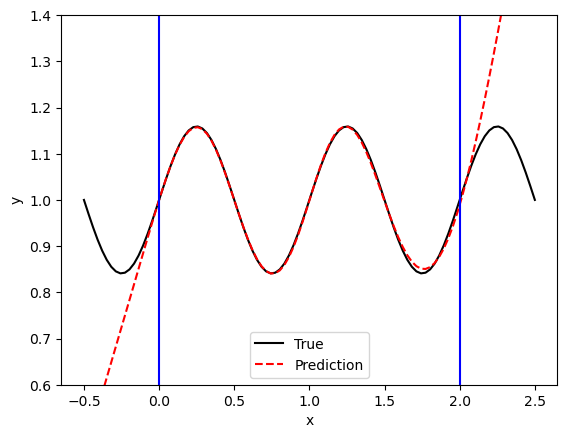

In [20]:
t_test = np.linspace(-0.5, 2.5, 100).reshape(-1, 1)

u_true = true_solution(t_test)
u_pred = model.predict(t_test)

plt.plot(t_test, u_true, 'k', label='True')
plt.plot(t_test, u_pred, 'r--', label='Prediction')
plt.xlabel('x')
plt.ylabel('y')
plt.axvline(0, color='b')
plt.axvline(2, color='b')
plt.ylim(0.6, 1.4)
plt.legend()
plt.show()